# Studies about gravitational waves, glitches on O3 run data - We need be able to obtain data from LIGO, HANFORD and VIRGO interferometers, manipulate this data and plot the results from O3 run.

## 1 Introduction

First we need import the necessary libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import gwpy

import seaborn as sns
import warnings
import math
import numpy as np
import datetime
import matplotlib.dates as mdates

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

from astropy.time import Time
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

import statistic_functions as ff

We can collect data in two main ways:

1 - from LigoDV-web (H1, L1, V1 - https://login.ligo.org/idp/profile/SAML2/Redirect/SSO?execution=e1s2) that **need of your LIGO credentials**.

2 - from Zenodo website (H1, L1 - https://zenodo.org/records/5649212) that **does't have V1 data**.

## 2 Clean the data and filter interesting features

You can make this all process with any interferometers. In our case is V1 from LigoDV-web.

### 2.1 To see the data in dataFrame mode, use pandas libraries

* **The O3 run have some duplicates data, depending on the source you got the data. This happens because some sources get data from multiple interferometers, or because the data have overlapping data segments in time windows. Furthermore, during data cleaning or combining different glitch catalogs (e.g., Gravity Spy + Omicron), indentical glitches might be added more than once. So, we use df.drop_duplicates()**

In [10]:
dfligo_V1_O3a = pd.read_csv("O3run data/V1_O3a_gspyLIGO.csv").drop_duplicates()
dfligo_V1_O3b = pd.read_csv("O3run data/V1_O3b_gspyLIGO.csv").drop_duplicates()

dfligo_V1_O3a.tail()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
80393,1.253167e+09,21.276,7.905,1.460000e-21,3680.246,2.013,7328.491699,0.0,0.0,0.187,axFS82a5rf,V1,Light_Modulation,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80394,1.253478e+09,19.950,7.959,1.800000e-21,42.988,0.500,53.975620,0.0,0.0,0.184,aH3vyF6Rc1,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80395,1.244633e+09,418.816,8.968,2.010000e-22,302.104,0.359,547.768860,0.0,0.0,0.177,fgQ0bycRBj,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80396,1.240533e+09,116.576,10.334,1.270000e-22,109.385,0.375,182.753067,0.0,0.0,0.172,vmTmg3Y2x0,V1,Scratchy,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,11.314
80397,1.241687e+09,349.985,8.376,1.570000e-22,324.817,0.703,600.853760,0.0,0.0,0.161,0o9ovV7MEB,V1,Koi_Fish,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627


### 2.2 To only filter glitches that have confidence vales above 90%

* **The reason why pipelines like Gravity Spy have relatively few glitches classified with confidence above 90% is due to a combination of factors. Glitches are highly diverse and often ambiguous, making them hard to classify with certainty. The machine learning models used are cautious and assign high confidence only when the classification is very clear. Additionally, the training data may be imbalanced, with some glitch types being rare or underrepresented. Visual similarities between categories can also reduce confidence. As a result, most confidence scores tend to fall below the 90% threshold, which is expected in complex multi-class classification problems.**

A lot glitches have no high confidence from its pipeline classification, see

In [14]:
above_90percent = (dfligo_V1_O3a['confidence'] >= 0.9).sum()
total = len(dfligo_V1_O3a)

percent = above_90percent / total
percent

0.5745789696261101

So lets only filter this nice glitches confidence for our analysis. The length of our data was decreased, see

In [16]:
clean_V1_O3a = dfligo_V1_O3a[dfligo_V1_O3a['confidence'] >= 0.9]
clean_V1_O3b = dfligo_V1_O3b[dfligo_V1_O3b['confidence'] >= 0.9]

clean_V1_O3a.shape

(46195, 15)

## 3 Analyze the frequency of each categorized glitch of O3 in general, but also splitting the analysis for O3a (April 1st 2019 - October 1st 2019) and O3b (November 1st 2019 - March 27th 2020) runs

### 3.1 The dominance of each glitch in O3a run

* **During the O3a and O3b observing runs, there was a clear dominance of certain glitch types, both in quantity and persistence over time. Blip glitches were especially prevalent during O3a, appearing frequently and relatively uniformly across different months. Other commonly observed types included scattered light, often associated with nighttime or seismic activity, and power line glitches, which are linked to persistent electrical noise. In contrast, categories such as low-frequency burst or 1400 ripple were much rarer and more localized, making statistical analysis and classifier training more difficult. This imbalance in glitch occurrence reflects both instrumental and environmental conditions that influence detector sensitivity and the nature of noise sources during different phases of the observation run.**

To count each glitch that we have, we use the **.value_counts()** function in the column **"label"** of our data

* If you prefer, the function **.nlargest(m)** after **.value_counts()** select the **"m"** biggest

In [21]:
glitch_countsO3a = clean_V1_O3a['label'].value_counts().sort_values(ascending=True)

In [22]:
glitch_countsO3a.head()

1080Lines             2
1400Ripples           4
Paired_Doves         67
Light_Modulation    103
Power_Line          119
Name: label, dtype: int64

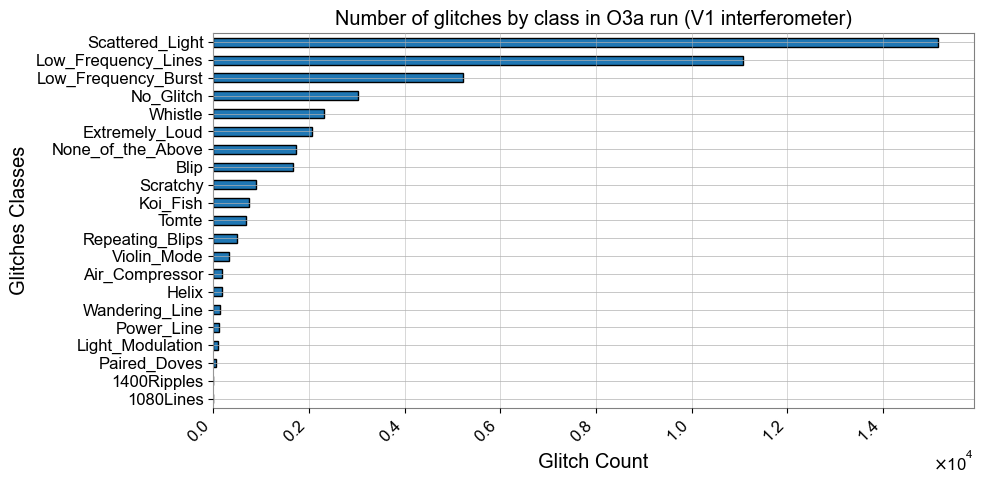

In [23]:
plt.figure(figsize=(10, 5))
glitch_countsO3a.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3a run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 And for O3b run we have

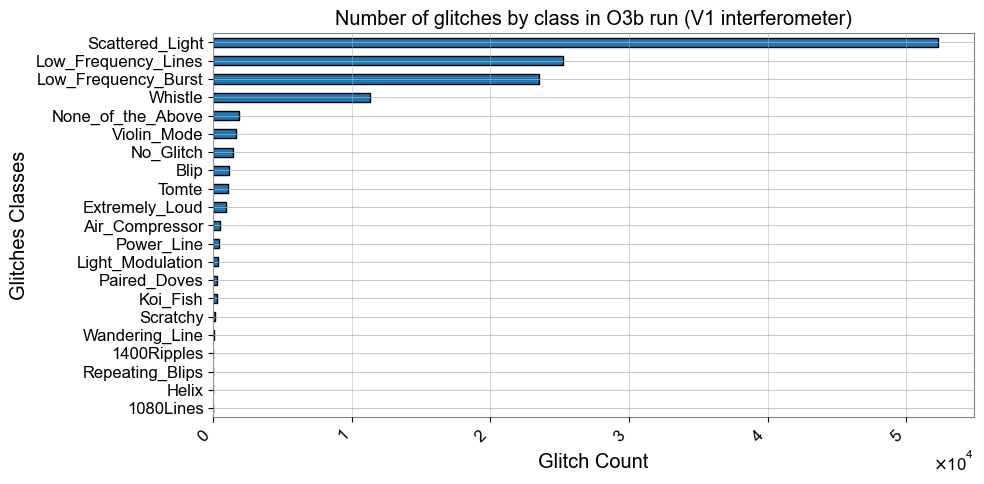

In [25]:
glitch_countsO3b = clean_V1_O3b['label'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 5))
glitch_countsO3b.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3b run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

We can see that **scattering-light** (and **fast-scattering** inside it) are the glitches that occurred the most during the O3b run - around November 1st 2019 - March 27th 2020. This agreed with Tabata teses (https://www.gov.br/inpe/pt-br/area-conhecimento/posgraduacao/ast/repositorio-de-arquivos/teses/tese_tabata_aira_ferreira.pdf)

## 4 Time-tracking of the incidence of each glitch category throughout O3 (by monthly, season, …)

In [28]:
clean_V1_O3a = clean_V1_O3a.sort_values(by='GPStime', ascending=True)
clean_V1_O3b = clean_V1_O3b.sort_values(by='GPStime', ascending=True)

clean_V1_O3a = clean_V1_O3a.reset_index(drop=True)
clean_V1_O3b = clean_V1_O3b.reset_index(drop=True)

print(clean_V1_O3a.index)
clean_V1_O3a.head()

RangeIndex(start=0, stop=46195, step=1)


,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1.238166e+09,118.526,12.088,1.090000e-22,211.877,0.094,331.946350,0.0,0.0,1.000,U9hF0CFicL,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
1,1.238167e+09,19.950,7.867,2.590000e-21,20.195,0.750,8.390090,0.0,0.0,0.998,cFEXeEnnvv,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
2,1.238167e+09,41.312,8.180,2.460000e-22,65.530,0.078,82.279373,0.0,0.0,1.000,7Rmzlmneu5,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
3,1.238167e+09,19.056,8.306,3.290000e-21,19.370,1.750,2.439150,0.0,0.0,0.965,pwXEfq8DlK,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255
4,1.238168e+09,340.202,12.113,1.970000e-22,357.194,0.313,218.644699,0.0,0.0,1.000,wiP1dmnUtc,V1,Whistle,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255


## 4.1 Amount of glitches per time

In [190]:
init_data_O3a = clean_V1_O3a.copy()
init_data_O3b = clean_V1_O3b.copy()

data that need to be modify according to your preferences

In [769]:
interval = 7*24*3600
glitches_number = 4
glitches_chosen = ['Scattered_Light', 'Low_Frequency_Lines', 'Low_Frequency_Burst', 'Koi_Fish']

In [771]:
interval

604800

count glitches inside each time_interval

In [774]:
glitch = init_data_O3a[init_data_O3a['label'] == 'Scattered_Light']

times = np.sort(glitch['GPStime'].values)

begin = times[0]
end = times[-1]

bins = np.arange(begin, end + interval, interval)

counts, _ = np.histogram(times, bins=bins)
bins = bins[1:]

plot the glitch count per time

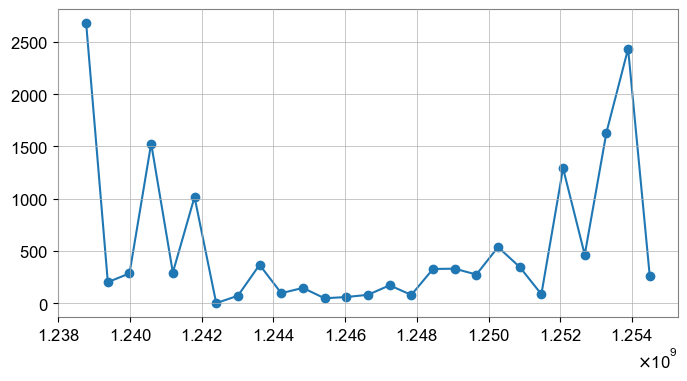

In [777]:
plt.figure(figsize=(8, 4))

plt.plot(bins, counts, marker='o', linestyle='-')

## 4.2 Rate of glitches per time

Now we will plot the rate of glitches per time, consider the operation time of the detector. This means that we will divide de glitches counts per detector operation time in each time_interval chosen. Fot this, we need

1 - Read the segments (start, end)

2 - Divide the total observation time into weeks (bins)

3 - For each week: See which segment parts overlap with that week and add the intersection time (tme the detector was on within that week)

In [786]:
df = pd.read_csv('gwosc.org.txt', sep=' ', header=None, names=['start', 'end', 'duration'])

start_obs = df['start'].min()
end_obs = df['end'].max()

week_edges = np.arange(start_obs, end_obs + interval, interval)

active_time_per_week = []

for i in range(len(week_edges) - 1):
    week_start = week_edges[i]
    week_end = week_edges[i + 1]
    total_on = 0

    for _, row in df.iterrows():
        seg_start = row['start']
        seg_end = row['end']

        inter_start = max(week_start, seg_start)
        inter_end = min(week_end, seg_end)

        if inter_start < inter_end:
            total_on += inter_end - inter_start

    active_time_per_week.append(total_on)

result = pd.DataFrame({
    'week_start': week_edges[:-1],
    'week_end': week_edges[1:],
    'active_time': active_time_per_week
})

active = result['active_time'].values/interval
rate = active*counts

In [787]:
active

array([0.90043155, 0.94821925, 0.85955192, 0.84086806,
       0.90467923, 0.84346065, 0.77075397, 0.71246197,
       0.80419643, 0.75092758, 0.69509921, 0.75270172,
       0.74595899, 0.64654266, 0.39193948, 0.74542659,
       0.75731151, 0.68237434, 0.70342262, 0.77736772,
       0.72051918, 0.78191799, 0.7764914 , 0.82833995,
       0.69765873, 0.75904101, 0.10797288])

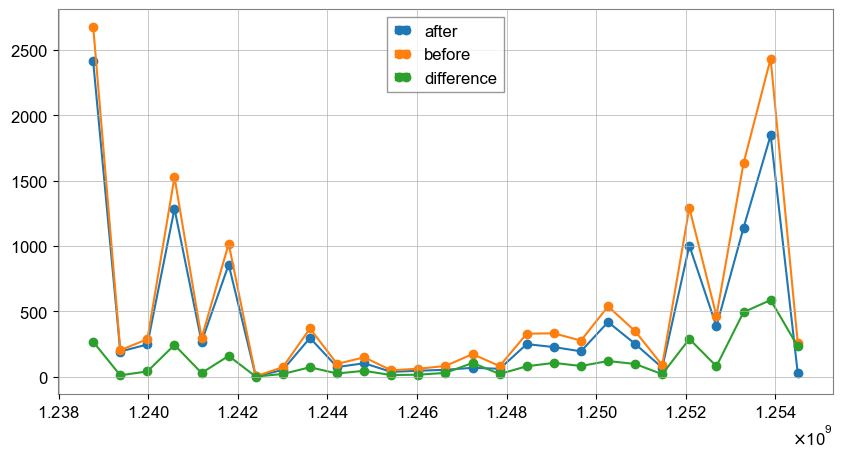

In [790]:
plt.figure(figsize=(10, 5))

plt.plot(bins, rate, marker='o', linestyle='-', label='after')
plt.plot(bins, counts, marker='o', linestyle='-', label='before')

plt.plot(bins, counts-rate, marker='o', linestyle='-', label='difference')
plt.legend()
plt.show()

## 4.3 phase space diagram

Now we will plot the glitches rate per number of glitches. If the Virgo detector was optimal condition, so the dots will be above of the ideal line y = x. If don',t so sometimes the detector was not working and dots will be a little below of the line.

eqation: rate = 0.83 * counts + -24.27


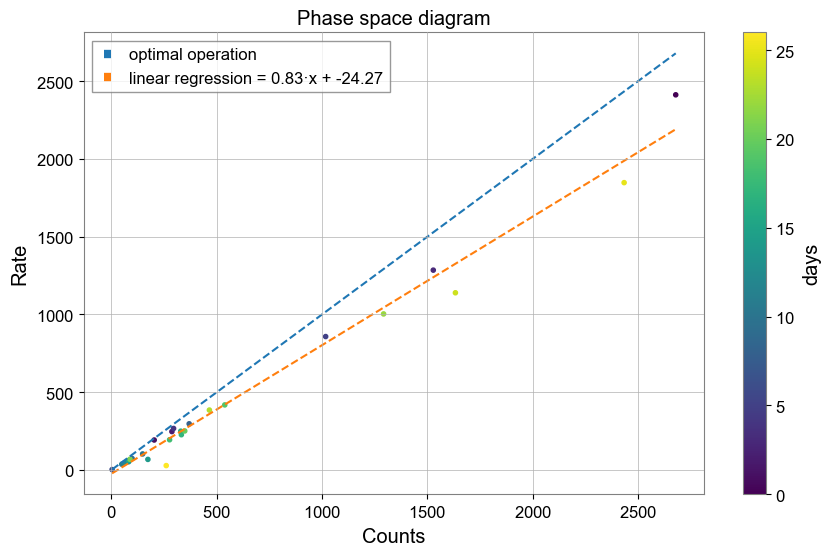

In [931]:
plt.figure(figsize=(10,6))
weeks = np.arange(len(counts))
scatter = plt.scatter(counts, rate, marker='.', c=weeks, cmap='viridis')
# plt.plot(counts, rate, marker='.')

x_ideal, y_ideal = np.linspace(min(counts), max(counts), 10), np.linspace(min(counts), max(counts), 10)
plt.plot(x_ideal, y_ideal, linestyle='--', label=f'optimal operation')


a, b = np.polyfit(counts, rate, deg=1)
print(f"eqation: rate = {a:.2f} * counts + {b:.2f}")

x_reg = np.linspace(min(counts), max(counts), 10)
y_reg = a * x_reg + b
plt.plot(x_reg, y_reg, '--', label=f'linear regression = {a:.2f}·x + {b:.2f}')


plt.title('Phase space diagram')
plt.xlabel('Counts')
plt.ylabel('Rate')

cbar = plt.colorbar(scatter)
cbar.set_label('days')
plt.legend()
plt.grid(True)
plt.show()

With zoom we can see better

In [807]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

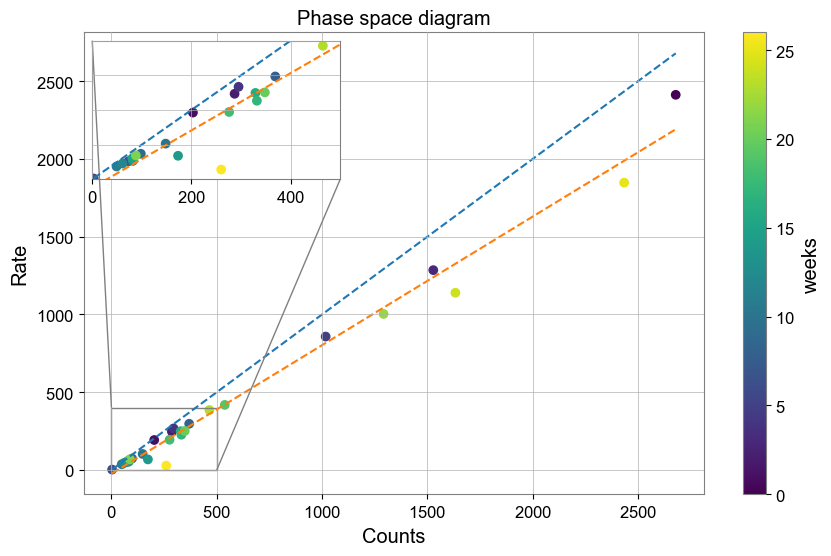

In [935]:
plt.figure(figsize=(10,6))
main_plt = plt.gca()

# main plot
weeks = np.arange(len(counts))
scatter = main_plt.scatter(counts, rate, marker='o', c=weeks, cmap='viridis')

# details main plot
main_plt.set_title('Phase space diagram')
main_plt.set_xlabel('Counts')
main_plt.set_ylabel('Rate')

# ideal line for detector y = x
x_ideal, y_ideal = np.linspace(min(counts), max(counts), 10), np.linspace(min(counts), max(counts), 10)
main_plt.plot(x_ideal, y_ideal, linestyle='--', label=f'optimal operation')

# linear regression
a, b = np.polyfit(counts, rate, deg=1)
x_reg = np.linspace(min(counts), max(counts), 10)
y_reg = a * x_reg + b
main_plt.plot(x_reg, y_reg, '--', label=f'linear regression = {a:.2f}·x + {b:.2f}')

# inset plot
axins = inset_axes(main_plt, width="40%", height="30%", loc='upper left')

axins.scatter(counts, rate, marker='o', c=weeks, cmap='viridis')
axins.plot(x_ideal, y_ideal, linestyle='--', label=f'optimal operation')
axins.plot(x_reg, y_reg, '--', label=f'linear regression = {a:.2f}·x + {b:.2f}')

# Define limits for zoom
x1, x2 = 0, 500
y1, y2 = 0, 400
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Conection between both graph
mark_inset(main_plt, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# details
axins.tick_params(axis='y', left=False, labelleft=False)
cbar = plt.colorbar(scatter)
cbar.set_label('weeks')
plt.grid(True)
plt.show()

## 4.4 Correlation matrix for similar visual glitches (we can automate this ?)

Visually by the behavior of the graphics (subsection 4.1), we can assume that there is a related behavior between the **Scattered Light, Low Freqency Lines and Low Frequency Busrt**. So we'll construct the correlation matrix between them.

In [311]:
gps_epoch = pd.Timestamp('1980-01-06 00:00:00', tz='UTC')

matrix_values = []
for i in range(glitches_number):
    
    df = init_data_O3a[init_data_O3a['label'] == glitches_chosen[i]].copy()
    df.index = gps_epoch + pd.to_timedelta(df['GPStime'], unit='s')
    
    data_matrix = df.resample(time_key).size()
    matrix_values.append(data_matrix.values)

In [313]:
matrix_values

[array([2649,  222,  247, 1478,  379,  945,   92,   58,  378,
          74,  171,   42,   69,   54,  128,  159,  237,  412,
         279,  531,  355,   96, 1172,  519, 1498, 2152,  745],
       dtype=int64),
 array([1432,  234,  112, 1427,  310, 1328,   27,   80,  290,
         130,  136,   77,   65,   80,  171,  205,  307,  563,
         392,  329,  506,  174,  359,  384, 1002,  751,  191],
       dtype=int64),
 array([291,  93,  77, 523, 142, 348,  67,  20, 235, 110, 120,
         46, 105,  41, 203, 269, 342, 411,  77, 131, 104,  46,
        303, 133, 396, 494,  96], dtype=int64),
 array([10, 31, 32, 45, 37, 42,  0, 16, 44, 35, 27, 27, 31, 49,
        22, 31, 22, 27, 26, 26, 25, 27, 31, 19, 31, 26,  6],
       dtype=int64)]

this result shows how many glitches occurred at each time **time_key**, for all glitches in **glitches_chosen**. So our correlation matrix will be

In [316]:
x = matrix_values[0]
y = matrix_values[1]
z = matrix_values[2]
w = matrix_values[3]

df = pd.DataFrame([x, y, z, w]).T
df.columns = ['ScatLight', 'Low_Fr_Lin', 'Low_Fr_Bur', 'Koi_Fish']

corr_matrix = df.corr()
print(corr_matrix)

            ScatLight  Low_Fr_Lin  Low_Fr_Bur  Koi_Fish
ScatLight    1.000000    0.821224    0.688453 -0.080633
Low_Fr_Lin   0.821224    1.000000    0.741256  0.163819
Low_Fr_Bur   0.688453    0.741256    1.000000  0.235393
Koi_Fish    -0.080633    0.163819    0.235393  1.000000


The correlation ranges from -1 to 1. The closer to the ends, the greater the correlation between the classes (being maximally directly correlated at 1 and maximally inversely correlated at -1), and the closer to 0, the less correlated the classes are. Note that the main diagonal will have all values ​​equal to 1, since any class is fully correlated with itself.

From this result we see that Scattering Light is about 63% correlated to Low_Frequency Lines (very similar blue and orange curves), while only 1.4% inversely correlated to Koi Fish (reflected by the differences between the blue and red curves)

**trash**

from gwpy.timeseries import TimeSeries
from scipy.fft import fft, ifft, fftfreq

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
data = {
    'x': [45, 37, 42, 35, 39],
    'y': [38, 31, 26, 28, 33],
    'z': [10, 15, 17, 21, 12]
}
dataframe = pd.DataFrame(data, columns=['x', 'y', 'z'])
print("Dataframe is : ")
print(dataframe)
matrix = dataframe.corr()
print("Correlation matrix is : ")
print(matrix)